In [6]:
import requests
import time
import pandas as pd

# ================= CONFIGURAÇÕES =================
API_KEY = "cDZHYzlZa0JadVREZDJCendQbXY6SkJlTzNjLV9TRENyQk1RdnFKZGRQdw==" 
URL_API = "https://api-publica.datajud.cnj.jus.br/api_publica_tjce/_search"
META_PROCESSOS = 1000 

def criar_query(cursor_paginacao=None):
    """Monta o payload de busca para o ElasticSearch (DataJud - TJCE)."""
    body = {
        "size": 100,
        "query": {
            "bool": {
                "must": [
                    { "match": { "tribunal": "TJCE" } },
                    { "match": { "grau": "G1" } },
                    { "match": { "assuntos.nome": "Crimes contra a fauna" } }, 
                    # --- ALTERAÇÃO AQUI: INTERVALO DA "ERA DE OURO" DO E-SAJ ---
                    { 
                        "range": { 
                            "movimentos.dataHora": { 
                                "gte": "2015-01-01T00:00:00",
                                "lte": "2019-12-31T23:59:59"
                            } 
                        } 
                    },
                    # -----------------------------------------------------------
                    { "terms": { "movimentos.codigo": [219, 220, 221] } }
                ],
                "must_not": [ 
                    { "match_phrase": { "orgaoJulgador.nome": "TURMA" } },
                    { "match_phrase": { "orgaoJulgador.nome": "RELATOR" } }
                ]
            }
        },
        "sort": [{"@timestamp": "desc"}],
        "_source": ["numeroProcesso", "movimentos", "assuntos", "orgaoJulgador"]
    }
    
    if cursor_paginacao:
        body["search_after"] = cursor_paginacao
        
    return body

def formatar_nup(nup):
    s = str(nup).strip().zfill(20)
    return f"{s[:7]}-{s[7:9]}.{s[9:13]}.{s[13:14]}.{s[14:16]}.{s[16:20]}"

def main():
    headers = {
        "Authorization": f"APIKey {API_KEY}",
        "Content-Type": "application/json"
    }
    dados_coletados = []
    cursor = None 

    print(f"--- Coletando Processos Antigos TJCE (2015-2019) ---")

    while len(dados_coletados) < META_PROCESSOS:
        try:
            resp = requests.post(URL_API, headers=headers, json=criar_query(cursor), timeout=50)
            
            if resp.status_code != 200:
                print(f"⚠ Erro API: {resp.status_code} - Tentando novamente...")
                time.sleep(5)
                continue

            hits = resp.json().get('hits', {}).get('hits', [])
            if not hits:
                print(" Fim dos resultados disponíveis na API.")
                break

            for hit in hits:
                src = hit.get('_source', {})
                orgao = src.get('orgaoJulgador', {}).get('nome', '').upper()
                nup_raw = src.get('numeroProcesso')
                
                lista_assuntos = [a['nome'] for a in src.get('assuntos', []) if 'nome' in a]
                texto_assuntos = "; ".join(lista_assuntos)

                codigos_sentenca = [219, 220, 221]
                movs = sorted(src.get('movimentos', []), key=lambda x: x.get('dataHora', ''), reverse=True)
                decisao = next((m['nome'] for m in movs if m.get('codigo') in codigos_sentenca), "Sentença Genérica")

                dados_coletados.append({
                    "NUP": nup_raw,
                    "NUP_Formatado": formatar_nup(nup_raw),
                    "Unidade": orgao,
                    "Assuntos": texto_assuntos,
                    "Decisao": decisao
                })

            cursor = hits[-1]['sort']
            print(f"Processos coletados: {len(dados_coletados)}")
            
            if len(dados_coletados) >= META_PROCESSOS:
                break
                
        except Exception as e:
            print(f" Erro crítico: {e}")
            break

    # Salva o resultado
    if dados_coletados:
        nome_arquivo = "lista_tjce_fauna_antigos2.csv"
        df = pd.DataFrame(dados_coletados[:META_PROCESSOS])
        df.to_csv(nome_arquivo, index=False, sep=';', encoding='utf-8-sig')
        print(f"\n Arquivo '{nome_arquivo}' gerado com sucesso!")
    else:
        print("\n Nenhum dado encontrado neste período.")

if __name__ == "__main__":
    main()

--- Coletando Processos Antigos TJCE (2015-2019) ---
Processos coletados: 100
Processos coletados: 200
Processos coletados: 300
Processos coletados: 400
Processos coletados: 500
Processos coletados: 600
Processos coletados: 700
Processos coletados: 800
Processos coletados: 900
Processos coletados: 1000

 Arquivo 'lista_tjce_fauna_antigos.csv' gerado com sucesso!


In [5]:
# !pip install -U selenium webdriver-manager

In [ ]:
import os
import time
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# ================= CONFIGURAÇÕES DE CAMINHO =================
ARQUIVO_ENTRADA = "lista_tjce_fauna_antigos.csv"
PASTA_DESTINO = r"C:\Users\igo.costa\Desktop\TrabalhoPNL\PNLFinal\Baixados" 
URL_ESAJ = "https://esaj.tjce.jus.br/cpopg/open.do"

# ================= CONFIGURAÇÃO DE LOTE (MUDE AQUI) =================
START_IDX = 0      # <--- Começar na linha
END_IDX   = 10     # <--- Parar na linha 
# ====================================================================

if not os.path.exists(PASTA_DESTINO):
    os.makedirs(PASTA_DESTINO)

def configurar_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--ignore-certificate-errors")
    options.add_argument("--start-maximized")
    options.add_argument("--disable-gpu")
    
    prefs = {
        "download.default_directory": PASTA_DESTINO,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "plugins.always_open_pdf_externally": False, 
        "safebrowsing.enabled": True
    }
    options.add_experimental_option("prefs", prefs)
    
    return webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

def formatar_nup(nup):
    clean = re.sub(r'\D', '', str(nup)).zfill(20)
    return {
        "num_unificado": f"{clean[0:7]}-{clean[7:9]}.{clean[9:13]}",
        "foro": clean[16:20]
    }

def expandir_movimentacoes(driver):
    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        try:
            link_mov = driver.find_element(By.ID, "linkMovimentacoes")
            if link_mov.is_displayed():
                driver.execute_script("arguments[0].click();", link_mov)
                time.sleep(1)
        except: pass

        tentativas = 0
        while tentativas < 5:
            clicou_algo = False
            links = driver.find_elements(By.TAG_NAME, "a")
            for link in links:
                if "Mais" in link.text and link.is_displayed():
                    try:
                        driver.execute_script("arguments[0].click();", link)
                        time.sleep(0.5)
                        clicou_algo = True
                    except: pass
            
            if not clicou_algo:
                break
                
            time.sleep(1)
            tentativas += 1
    except: pass

def esperar_novo_arquivo_e_renomear(pasta, arquivos_antes, nup_formatado, timeout=60):
    fim = time.time() + timeout
    while time.time() < fim:
        try:
            arquivos_agora = set(os.listdir(pasta))
            novos = arquivos_agora - arquivos_antes
            novos_pdfs = [f for f in novos if f.endswith(".pdf")]
            
            if novos_pdfs:
                nome_arquivo_novo = novos_pdfs[0]
                caminho_origem = os.path.join(pasta, nome_arquivo_novo)
                time.sleep(1) 
                caminho_final = os.path.join(pasta, f"{nup_formatado}.pdf")
                
                if os.path.exists(caminho_final):
                    try: os.remove(caminho_final)
                    except: pass
                
                tentativas = 0
                while tentativas < 5:
                    try:
                        os.rename(caminho_origem, caminho_final)
                        return True
                    except:
                        time.sleep(1)
                        tentativas += 1
        except: pass
        time.sleep(1)
    return False

def tentar_clicar_botoes(driver):
    seletores = [
        (By.ID, "download"), 
        (By.CSS_SELECTOR, "button[title='Baixar']"),
        (By.CSS_SELECTOR, "button[title='Download']"),
        (By.ID, "botaoSalvar"),
        (By.CSS_SELECTOR, ".toolbarButton.download"),
        (By.ID, "secondaryDownload")
    ]
    for by, selector in seletores:
        try:
            botao = driver.find_element(by, selector)
            if botao.is_displayed():
                driver.execute_script("arguments[0].click();", botao)
                return True
        except: continue
    return False

def clicar_botao_baixar_popup(driver, wait):
    try:
        if tentar_clicar_botoes(driver): return True
        frames = driver.find_elements(By.TAG_NAME, "iframe")
        for frame in frames:
            try:
                driver.switch_to.frame(frame)
                if tentar_clicar_botoes(driver):
                    driver.switch_to.default_content()
                    return True
                driver.switch_to.default_content()
            except:
                driver.switch_to.default_content()
    except: pass
    return False

def processar_sentenca(driver, wait, nup_formatado):
    expandir_movimentacoes(driver)
    gatilhos = ["julgado improcedente", "julgado procedente", "sentença", "extinguindo", "mérito"]
    
    try:
        wait.until(EC.presence_of_element_located((By.ID, "tabelaTodasMovimentacoes")))
        linhas = driver.find_elements(By.CSS_SELECTOR, "#tabelaTodasMovimentacoes tr")
        janela_principal = driver.current_window_handle
        
        for linha in linhas:
            texto_linha = linha.text
            texto_lower = texto_linha.lower()
            
            if any(g in texto_lower for g in gatilhos):
                teor_movimentacao = texto_linha.replace("\n", " || ").strip()
                try:
                    links = linha.find_elements(By.TAG_NAME, "a")
                    for link in links:
                        if link.is_displayed():
                            arquivos_antes = set(os.listdir(PASTA_DESTINO))
                            driver.execute_script("arguments[0].click();", link)
                            wait.until(EC.number_of_windows_to_be(2))
                            
                            janelas = driver.window_handles
                            driver.switch_to.window(janelas[-1])
                            time.sleep(3) 
                            
                            clicou = clicar_botao_baixar_popup(driver, WebDriverWait(driver, 5))
                            status = "Sucesso" if clicou and esperar_novo_arquivo_e_renomear(PASTA_DESTINO, arquivos_antes, nup_formatado) else "Erro Download"
                            
                            driver.close()
                            driver.switch_to.window(janela_principal)
                            return status, teor_movimentacao
                except:
                    if len(driver.window_handles) > 1:
                        driver.close()
                        driver.switch_to.window(janela_principal)
                    continue
    except: pass
    return "Documento não encontrado", ""

def main():
    if not os.path.exists(ARQUIVO_ENTRADA):
        return print(f"❌ Arquivo '{ARQUIVO_ENTRADA}' não encontrado.")

    # CARREGANDO E FILTRANDO O LOTE
    df_completo = pd.read_csv(ARQUIVO_ENTRADA, sep=';', encoding='utf-8-sig')
    df = df_completo.iloc[START_IDX:END_IDX].copy()

    print(f"--- Iniciando Robô TJCE (Lote: {START_IDX} até {END_IDX}) ---")
    print(f"📊 Total de processos neste turno: {len(df)}")

    if 'Status_Download' not in df.columns: df['Status_Download'] = None
    if 'Magistrado_Scraping' not in df.columns: df['Magistrado_Scraping'] = None
    if 'Teor_Movimentacao' not in df.columns: df['Teor_Movimentacao'] = None

    driver = configurar_driver()
    wait = WebDriverWait(driver, 20)

    try:
        for index, row in df.iterrows():
            nup = row.get('NUP_Formatado', row.get('NUP', ''))
            print(f"\n[{index}] Processando: {nup}")

            try:
                driver.get(URL_ESAJ)
                dados = formatar_nup(nup)
                driver.execute_script("arguments[0].value = arguments[1];", wait.until(EC.presence_of_element_located((By.ID, "numeroDigitoAnoUnificado"))), dados['num_unificado'])
                driver.execute_script("arguments[0].value = arguments[1];", driver.find_element(By.ID, "foroNumeroUnificado"), dados['foro'])
                driver.find_element(By.ID, "botaoConsultarProcessos").click()

                wait.until(lambda d: d.find_elements(By.CLASS_NAME, "secaoFormBody") or d.find_elements(By.ID, "mensagemRetorno") or d.find_elements(By.ID, "senhaProcesso") or d.find_elements(By.ID, "processoSelecionado"))

                if driver.find_elements(By.ID, "senhaProcesso") and driver.find_elements(By.ID, "senhaProcesso")[0].is_displayed():
                    df.at[index, 'Status_Download'] = "Segredo de Justiça"
                    continue
                
                if driver.find_elements(By.ID, "processoSelecionado"):
                    driver.find_elements(By.ID, "processoSelecionado")[0].click()
                    driver.find_element(By.ID, "botaoEnviar").click()

                try:
                    juiz = driver.find_element(By.ID, "juizProcesso").text.strip()
                    df.at[index, 'Magistrado_Scraping'] = juiz
                except: pass

                status, texto_mov = processar_sentenca(driver, wait, nup)
                df.at[index, 'Status_Download'] = status
                df.at[index, 'Teor_Movimentacao'] = texto_mov
                print(f"   > {status}")

            except Exception as e:
                print(f"   > Erro no processo: {e}")
                
    except KeyboardInterrupt:
        print("\n⏹ Parado pelo usuário.")
    finally:
        driver.quit()
        nome_log = f"log_tjce_{START_IDX}_a_{END_IDX}.csv"
        df.to_csv(os.path.join(PASTA_DESTINO, nome_log), index=False, sep=';', encoding='utf-8-sig')
        print(f"\n✅ Finalizado! Relatório salvo como: {nome_log}")

if __name__ == "__main__":
    main()

In [ ]:
#!pip install -U pypdf pdfplumber pandas

In [25]:
import os
import re
import pandas as pd
import pdfplumber

# =================== CAMINHOS (SEUS) ===================
PASTA_PDFS = r"C:\Users\igo.costa\Desktop\TrabalhoPNL\PNLFinal\Baixados"
CSV_LOG = os.path.join(PASTA_PDFS, "log_tjce_0_a_10.csv")
SAIDA = os.path.join(PASTA_PDFS, "log_downloads_tjce_com_magistrado_pdf.csv")

# =======================================================

def normalizar_espacos(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_texto_pdf(caminho_pdf: str, ultimas_paginas: int = 3, primeiras_paginas: int = 1) -> str:
    textos = []
    try:
        with pdfplumber.open(caminho_pdf) as pdf:
            n = len(pdf.pages)

            # primeiras páginas (às vezes trazem cabeçalho útil)
            for i in range(min(primeiras_paginas, n)):
                t = pdf.pages[i].extract_text() or ""
                if t.strip():
                    textos.append(t)

            # últimas páginas (assinaturas costumam ficar aqui)
            start = max(0, n - ultimas_paginas)
            for i in range(start, n):
                t = pdf.pages[i].extract_text() or ""
                if t.strip():
                    textos.append(t)

    except Exception:
        return ""

    return "\n".join(textos)

def limpar_nome(nome: str) -> str:
    nome = normalizar_espacos(nome)
    nome = re.sub(r"^(?:Dr\.?|Dra\.?)\s+", "", nome, flags=re.IGNORECASE)
    nome = re.sub(r"\s*\(.*?\)\s*$", "", nome)
    if len(nome) < 6:
        return ""
    return nome

def extrair_magistrado_do_texto(texto: str) -> str:
    if not texto:
        return ""

    t = texto

    # 1) Assinatura típica: NOME + cargo na linha seguinte
    padroes_assinatura = [
        r"\n([A-ZÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ][A-Za-zÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ'\-\. ]{8,80})\s*\n\s*(Ju[ií]z(?:a)? de Direito)\b",
        r"\n([A-ZÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ][A-Za-zÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ'\-\. ]{8,80})\s*\n\s*(Desembargador(?:a)?)\b",
        r"\n([A-ZÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ][A-Za-zÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ'\-\. ]{8,80})\s*\n\s*(Ju[ií]z(?:a)?(?: Substitut[oa])?)\b",
    ]
    for p in padroes_assinatura:
        m = re.search(p, t, flags=re.IGNORECASE)
        if m:
            return limpar_nome(m.group(1))

    # 2) Rótulos: "Juiz(a): NOME" / "Magistrado: NOME" / "Relator(a): NOME"
    padroes_rotulo = [
        r"\bJu[ií]z(?:a)?\s*[:\-]\s*([A-ZÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ][A-Za-zÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ'\-\. ]{8,80})",
        r"\bMagistrad[oa]\s*[:\-]\s*([A-ZÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ][A-Za-zÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ'\-\. ]{8,80})",
        r"\bRelator(?:a)?\s*[:\-]\s*([A-ZÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ][A-Za-zÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ'\-\. ]{8,80})",
    ]
    for p in padroes_rotulo:
        m = re.search(p, t, flags=re.IGNORECASE)
        if m:
            return limpar_nome(m.group(1))

    # 3) Fallback: linha anterior a "Juíza/Juiz de Direito"
    linhas = [normalizar_espacos(x) for x in t.splitlines() if normalizar_espacos(x)]
    for i, ln in enumerate(linhas):
        if re.search(r"\bJu[ií]z(?:a)? de Direito\b", ln, flags=re.IGNORECASE):
            if i > 0:
                cand = linhas[i - 1]
                if (len(cand) <= 80) and (not re.search(r"\d", cand)) and (len(cand.split()) >= 2):
                    return limpar_nome(cand)

    return ""

def extrair_magistrado_pdf(caminho_pdf: str) -> tuple[str, str]:
    texto = extrair_texto_pdf(caminho_pdf, ultimas_paginas=3, primeiras_paginas=1)

    if not texto.strip():
        return "", "Sem texto extraível (PDF imagem/OCR necessário)"

    mag = extrair_magistrado_do_texto(texto)
    if mag:
        return mag, "OK"

    return "", "Texto extraído, mas padrão não encontrado"

# =================== EXECUÇÃO ===================
if not os.path.exists(CSV_LOG):
    raise FileNotFoundError(f"Não achei o CSV em: {CSV_LOG}")

df = pd.read_csv(CSV_LOG, sep=";", encoding="utf-8-sig")

# Garante colunas
if "Magistrado_PDF" not in df.columns:
    df["Magistrado_PDF"] = ""
if "Obs_Magistrado_PDF" not in df.columns:
    df["Obs_Magistrado_PDF"] = ""

# Define qual coluna indica "já tem juiz"
# (se a sua coluna antiga chama 'Magistrado_Scraping', usamos ela como referência)
col_mag_existente = "Magistrado_Scraping" if "Magistrado_Scraping" in df.columns else None

def tem_magistrado_existente(row) -> bool:
    if not col_mag_existente:
        return False
    val = str(row.get(col_mag_existente, "")).strip()
    return val and val.lower() != "nan"

total = len(df)
processados = 0
pulados = 0
encontrados = 0
sem_texto = 0

# =================== EXECUÇÃO CORRIGIDA ===================
for idx, row in df.iterrows():
    nup_fmt = str(row.get("NUP_Formatado", "")).strip()
    nup_raw = str(row.get("NUP", "")).strip()
    candidato = nup_fmt if nup_fmt and nup_fmt.lower() != "nan" else nup_raw

    # Verifica se o arquivo físico existe
    caminho_pdf = os.path.join(PASTA_PDFS, f"{candidato}.pdf")
    
    if not os.path.exists(caminho_pdf):
        df.at[idx, "Obs_Magistrado_PDF"] = "PDF não encontrado na pasta"
        processados += 1
        continue

    # FORÇA A EXTRAÇÃO DO PDF (Ignorando se já tem nome no CSV de log)
    mag_pdf, obs = extrair_magistrado_pdf(caminho_pdf)
    
    # Salvamos em uma coluna separada para você poder comparar
    df.at[idx, "Magistrado_PDF"] = mag_pdf
    df.at[idx, "Obs_Magistrado_PDF"] = obs

    # Opcional: Criar uma coluna 'Magistrado_Final' que prefere o PDF ao Scraping
    if mag_pdf:
        df.at[idx, "Magistrado_Dataset_Limpo"] = mag_pdf
    else:
        df.at[idx, "Magistrado_Dataset_Limpo"] = row.get("Magistrado_Scraping", "")

    processados += 1
# Salva
df.to_csv(SAIDA, index=False, sep=";", encoding="utf-8-sig")

print("✅ Concluído!")
print("Arquivo de saída:", SAIDA)
print(f"Total linhas: {total}")
print(f"Pulados (já tinham magistrado): {pulados}")
print(f"Processados (tentativa via PDF): {processados}")
print(f"Encontrados via PDF: {encontrados}")
print(f"Sem texto extraível: {sem_texto}")

✅ Concluído!
Arquivo de saída: C:\Users\igo.costa\Desktop\TrabalhoPNL\PNLFinal\Baixados\log_downloads_tjce_com_magistrado_pdf.csv
Total linhas: 10
Pulados (já tinham magistrado): 0
Processados (tentativa via PDF): 10
Encontrados via PDF: 0
Sem texto extraível: 0


In [16]:
#!pip install unidecode pandas

In [26]:
import os
import pandas as pd

# =================== CAMINHOS (SEUS) ===================
BASE = r"C:\Users\igo.costa\Desktop\TrabalhoPNL\PNLFinal\Baixados"
ARQ_IN = os.path.join(BASE, "log_downloads_tjce_com_magistrado_pdf.csv")
ARQ_OUT = os.path.join(BASE, "dataset_tjce_limpo.csv")
# =======================================================

df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8-sig")

# 1) Garante que NUP_Formatado exista (se não existir, tenta usar NUP)
if "NUP_Formatado" not in df.columns:
    if "NUP" in df.columns:
        df["NUP_Formatado"] = df["NUP"]
    else:
        raise ValueError("Não encontrei 'NUP_Formatado' nem 'NUP' no arquivo.")

# 2) Mescla magistrado: prioriza PDF; se vazio, usa Scraping
def escolher_magistrado(row):
    pdf = str(row.get("Magistrado_PDF", "")).strip()
    scr = str(row.get("Magistrado_Scraping", "")).strip()
    if pdf and pdf.lower() != "nan":
        return pdf
    if scr and scr.lower() != "nan":
        return scr
    return ""

df["Magistrado"] = df.apply(escolher_magistrado, axis=1)

# 3) Mantém apenas as colunas desejadas (se alguma não existir, cria vazia)
cols_desejadas = ["NUP_Formatado", "Decisao", "Magistrado", "Teor_Movimentacao"]
for c in cols_desejadas:
    if c not in df.columns:
        df[c] = ""

df_limpo = df[cols_desejadas].copy()

# 4) Remove linhas sem magistrado (causa dos "indeterminados")
antes = len(df_limpo)
df_limpo["Magistrado"] = df_limpo["Magistrado"].fillna("").astype(str).str.strip()
df_limpo = df_limpo[df_limpo["Magistrado"].str.len() > 0].copy()
depois = len(df_limpo)

# 5) (Opcional recomendado) remove duplicados por processo, se houver
df_limpo = df_limpo.drop_duplicates(subset=["NUP_Formatado"]).copy()

# 6) Salva
df_limpo.to_csv(ARQ_OUT, index=False, sep=";", encoding="utf-8-sig")

print("✅ Dataset limpo gerado!")
print("Arquivo:", ARQ_OUT)
print(f"Linhas antes: {antes}")
print(f"Linhas após remover sem magistrado: {depois}")
print(f"Linhas após deduplicação por NUP_Formatado: {len(df_limpo)}")
print("\nPrévia:")
display(df_limpo.head(5))


✅ Dataset limpo gerado!
Arquivo: C:\Users\igo.costa\Desktop\TrabalhoPNL\PNLFinal\Baixados\dataset_tjce_limpo.csv
Linhas antes: 10
Linhas após remover sem magistrado: 9
Linhas após deduplicação por NUP_Formatado: 9

Prévia:


,NUP_Formatado,Decisao,Magistrado,Teor_Movimentacao
0,0001494-18.2007.8.06.0128,Procedência em Parte,Diogo Schenatto Irion,NaN
1,0111667-87.2016.8.06.0001,Procedência,Francisco Gilmario Barros Lima,03/03/2021 Julgado procedente o pedido || Post...
2,0004685-26.2017.8.06.0159,Procedência em Parte,Ana Claudia Gomes de Melo,23/06/2022 Julgado procedente em parte do pedi...
3,0005923-12.2000.8.06.0051,Procedência,DAYANA CLAUDIA TAVARES BARROS DE CASTRO,NaN
4,0000728-46.2019.8.06.0159,Procedência em Parte,Ricardo de Araújo Barreto,12/06/2023 Proferido despacho de mero expedien...


In [31]:
import os
import re
import time
import pandas as pd
import requests
from unidecode import unidecode

# =================== CAMINHOS (SEUS) ===================
BASE = r"C:\Users\igo.costa\Desktop\TrabalhoPNL\PNLFinal\Baixados"
ARQ_IN = os.path.join(BASE, "dataset_tjce_limpo.csv")
ARQ_OUT = os.path.join(BASE, "dataset_tjce_limpo_com_genero_v2.csv")

# Cache local para não baixar IBGE toda vez
CACHE_IBGE_F = os.path.join(BASE, "ibge_ranking_f.csv")
CACHE_IBGE_M = os.path.join(BASE, "ibge_ranking_m.csv")
# =======================================================

# --- Parâmetros (ajuste se quiser) ---
QTD_RANKING = 20000          # quanto maior, maior cobertura
LIMIAR_CONFIANCA = 0.90      # antes era 0.90 (mais conservador)
TIMEOUT = 30

# ---------- utilitários ----------
def normalizar_token(s: str) -> str:
    return unidecode(str(s)).upper().strip()

def regra_juridica_por_texto(teor: str) -> str | None:
    """
    Prioridade máxima: se aparecer explicitamente Juiz/Juíza (ou Desembargador/a) no texto.
    """
    if not isinstance(teor, str):
        return None
    t = teor.lower()
    if "juíza de direito" in t or "juiza de direito" in t or "desembargadora" in t:
        return "Feminino"
    # cuidado: "desembargador" contém "desembargadora"? não, então ok
    if "juiz de direito" in t or "desembargador" in t:
        return "Masculino"
    return None

def heuristica_sufixo(nome: str) -> str:
    """
    Último recurso: heurística por sufixo.
    """
    if not nome:
        return "Indeterminado"
    n = unidecode(nome).lower()
    if n.endswith("a"):
        return "Feminino"
    if n.endswith("o"):
        return "Masculino"
    return "Indeterminado"

def extrair_prenomes(nome_completo: str) -> list[str]:
    """
    Retorna até 2 prenomes, removendo partículas comuns.
    Ex.: "Hercules Antonio Jacot Filho" -> ["Hercules", "Antonio"]
    """
    if not isinstance(nome_completo, str) or not nome_completo.strip():
        return []
    s = nome_completo.strip()
    s = re.sub(r"^(?:Dr\.?|Dra\.?)\s+", "", s, flags=re.IGNORECASE)

    partes = re.split(r"\s+", s)
    stop = {"de", "da", "do", "dos", "das", "d'", "di"}
    prenomes = []
    for p in partes:
        p_limpo = re.sub(r"[^A-Za-zÀ-ÿ\-']", "", p).strip()
        if not p_limpo:
            continue
        if p_limpo.lower() in stop:
            continue
        prenomes.append(p_limpo)
        if len(prenomes) == 2:
            break
    return prenomes

# ---------- IBGE ----------
def baixar_ranking_ibge(sexo: str, qtd: int) -> pd.DataFrame:
    """
    Baixa ranking de nomes por sexo (IBGE). Tenta v2 e v1.
    """
    assert sexo in ("f", "m")
    urls = [
        f"https://servicodados.ibge.gov.br/api/v2/censos/nomes/ranking?qtd={qtd}&sexo={sexo}",
        f"https://servicodados.ibge.gov.br/api/v1/censos/nomes/ranking?qtd={qtd}&sexo={sexo}",
    ]
    last_err = None

    for url in urls:
        try:
            r = requests.get(url, timeout=TIMEOUT)
            if r.status_code != 200:
                last_err = f"HTTP {r.status_code}"
                continue

            data = r.json()
            # comum: [{"localidade":"BR","sexo":"f","res":[{"nome":"MARIA","frequencia":...}, ...]}]
            if isinstance(data, list) and data and isinstance(data[0], dict) and "res" in data[0]:
                res = data[0]["res"]
            elif isinstance(data, list):
                res = data
            else:
                res = []

            df = pd.DataFrame(res)
            if df.empty or "nome" not in df.columns or "frequencia" not in df.columns:
                last_err = "Formato inesperado/vazio"
                continue

            df["nome_norm"] = df["nome"].astype(str).map(normalizar_token)
            df["frequencia"] = pd.to_numeric(df["frequencia"], errors="coerce").fillna(0).astype(int)
            df = df[["nome_norm", "frequencia"]].groupby("nome_norm", as_index=False).sum()
            return df

        except Exception as e:
            last_err = str(e)

    raise RuntimeError(f"Falha ao baixar ranking IBGE (sexo={sexo}). Último erro: {last_err}")

def carregar_ou_baixar_ibge():
    if os.path.exists(CACHE_IBGE_F) and os.path.exists(CACHE_IBGE_M):
        df_f = pd.read_csv(CACHE_IBGE_F)
        df_m = pd.read_csv(CACHE_IBGE_M)
        return df_f, df_m

    print("📥 Baixando ranking do IBGE (isso pode demorar um pouco)...")
    df_f = baixar_ranking_ibge("f", QTD_RANKING)
    time.sleep(1)
    df_m = baixar_ranking_ibge("m", QTD_RANKING)
    df_f.to_csv(CACHE_IBGE_F, index=False)
    df_m.to_csv(CACHE_IBGE_M, index=False)
    print("✅ Ranking IBGE baixado e cacheado.")
    return df_f, df_m

def construir_dict_prob(df_f: pd.DataFrame, df_m: pd.DataFrame) -> dict:
    """
    nome_norm -> (p_f, p_m, freq_f, freq_m)
    """
    f = df_f.set_index("nome_norm")["frequencia"].to_dict()
    m = df_m.set_index("nome_norm")["frequencia"].to_dict()
    nomes = set(f.keys()) | set(m.keys())

    out = {}
    for nm in nomes:
        ff = int(f.get(nm, 0))
        mm = int(m.get(nm, 0))
        tot = ff + mm
        if tot == 0:
            continue
        out[nm] = (ff / tot, mm / tot, ff, mm)
    return out

# =================== EXECUÇÃO ===================
if not os.path.exists(ARQ_IN):
    raise FileNotFoundError(f"Não encontrei o arquivo de entrada: {ARQ_IN}")

df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8-sig")

# garante colunas
if "Genero" not in df.columns:
    df["Genero"] = ""
if "Fonte_Genero" not in df.columns:
    df["Fonte_Genero"] = ""
if "Primeiro_Nome" not in df.columns:
    df["Primeiro_Nome"] = ""
if "Segundo_Nome" not in df.columns:
    df["Segundo_Nome"] = ""

df_f, df_m = carregar_ou_baixar_ibge()
prob = construir_dict_prob(df_f, df_m)

cont_juridico = cont_ibge = cont_sufixo = cont_ind = 0

for idx, row in df.iterrows():
    teor = row.get("Teor_Movimentacao", "")

    # 1) regra jurídica pelo texto
    g0 = regra_juridica_por_texto(teor)
    if g0:
        df.at[idx, "Genero"] = g0
        df.at[idx, "Fonte_Genero"] = "juridico_texto"
        cont_juridico += 1
        continue

    # 2) prenomes (até 2)
    prenomes = extrair_prenomes(str(row.get("Magistrado", "")))
    df.at[idx, "Primeiro_Nome"] = prenomes[0] if len(prenomes) > 0 else ""
    df.at[idx, "Segundo_Nome"] = prenomes[1] if len(prenomes) > 1 else ""

    if not prenomes:
        df.at[idx, "Genero"] = "Indeterminado"
        df.at[idx, "Fonte_Genero"] = "indeterminado_sem_nome"
        cont_ind += 1
        continue

    # 3) IBGE: tenta 1º e 2º prenome
    classificado = False
    for p in prenomes:
        nm = normalizar_token(p)
        if nm in prob:
            p_f, p_m, ff, mm = prob[nm]

            if p_f >= LIMIAR_CONFIANCA:
                df.at[idx, "Genero"] = "Feminino"
                df.at[idx, "Fonte_Genero"] = f"ibge({p}_pf={p_f:.2f})"
                cont_ibge += 1
                classificado = True
                break

            if p_m >= LIMIAR_CONFIANCA:
                df.at[idx, "Genero"] = "Masculino"
                df.at[idx, "Fonte_Genero"] = f"ibge({p}_pm={p_m:.2f})"
                cont_ibge += 1
                classificado = True
                break

    if classificado:
        continue

    # 4) sufixo como último recurso (testa primeiro e, se indeterminado, testa segundo)
    g = heuristica_sufixo(prenomes[0])
    fonte = "sufixo_1"
    if g == "Indeterminado" and len(prenomes) > 1:
        g = heuristica_sufixo(prenomes[1])
        fonte = "sufixo_2"

    df.at[idx, "Genero"] = g
    df.at[idx, "Fonte_Genero"] = fonte

    if g == "Indeterminado":
        cont_ind += 1
    else:
        cont_sufixo += 1

# salva
df.to_csv(ARQ_OUT, index=False, sep=";", encoding="utf-8-sig")

print("✅ Concluído!")
print("Arquivo:", ARQ_OUT)
print("\nDistribuição (Genero):")
print(df["Genero"].value_counts(dropna=False))
print("\nResumo:")
print(f"Total: {len(df)} | Juridico: {cont_juridico} | IBGE: {cont_ibge} | Sufixo: {cont_sufixo} | Indeterminado: {cont_ind}")
print("\nTop 15 Fonte_Genero:")
print(df["Fonte_Genero"].value_counts(dropna=False).head(15))


✅ Concluído!
Arquivo: C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\Kelsen\dataset_tjce_limpo_com_genero_v2.csv

Distribuição (Genero):
Genero
Masculino        390
Feminino         220
Indeterminado     92
Name: count, dtype: int64

Resumo:
Total: 702 | Juridico: 65 | IBGE: 268 | Sufixo: 277 | Indeterminado: 92

Top 15 Fonte_Genero:
Fonte_Genero
sufixo_1                   189
sufixo_2                   180
juridico_texto              65
ibge(Francisco_pm=1.00)     42
ibge(Bruno_pm=1.00)         20
ibge(Lucas_pm=1.00)         19
ibge(PAULO_pm=1.00)         14
ibge(Sandra_pf=1.00)        14
ibge(Bruna_pf=1.00)         13
ibge(Adriana_pf=1.00)       13
ibge(Luis_pm=1.00)          11
ibge(Antonio_pm=1.00)       11
ibge(José_pm=1.00)          10
ibge(Maria_pf=1.00)         10
ibge(Luiz_pm=1.00)           8
Name: count, dtype: int64


In [32]:
import os
import pandas as pd

BASE = r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final"
ARQ_IN = os.path.join(BASE, "dataset_tjce_limpo_com_genero_v2.csv")
ARQ_OUT = os.path.join(BASE, "dataset_tjce_final_sem_indeterminados.csv")

df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8-sig")

# Garantia mínima
if "Genero" not in df.columns:
    raise ValueError("Coluna 'Genero' não encontrada no arquivo de entrada.")

# Contagens antes
print("Antes (distribuição):")
print(df["Genero"].value_counts(dropna=False))

# Remove indeterminados e vazios
df["Genero"] = df["Genero"].fillna("").astype(str).str.strip()
df_final = df[df["Genero"].isin(["Masculino", "Feminino"])].copy()

# (Opcional) deduplicar por processo, se quiser garantir 1 linha por NUP
if "NUP_Formatado" in df_final.columns:
    df_final = df_final.drop_duplicates(subset=["NUP_Formatado"]).copy()

# Salva
df_final.to_csv(ARQ_OUT, index=False, sep=";", encoding="utf-8-sig")

print("\nDepois (distribuição):")
print(df_final["Genero"].value_counts(dropna=False))

print("\n✅ Dataset final sem indeterminados salvo em:")
print(ARQ_OUT)
print(f"Linhas antes: {len(df)} | Linhas depois: {len(df_final)}")


Antes (distribuição):
Genero
Masculino        390
Feminino         220
Indeterminado     92
Name: count, dtype: int64

Depois (distribuição):
Genero
Masculino    390
Feminino     220
Name: count, dtype: int64

✅ Dataset final sem indeterminados salvo em:
C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\Kelsen\dataset_tjce_final_sem_indeterminados.csv
Linhas antes: 702 | Linhas depois: 610


In [33]:
!pip install -U pdfplumber unidecode pandas

  Using cached Unidecode-1.4.0-py3-none-any.whl.metadata (13 kB)
Using cached Unidecode-1.4.0-py3-none-any.whl (235 kB)
  Attempting uninstall: unidecode
    Found existing installation: Unidecode 1.3.8
    Uninstalling Unidecode-1.3.8:
      Successfully uninstalled Unidecode-1.3.8


In [34]:
import os
import re
import pandas as pd
import pdfplumber
from unidecode import unidecode

# =================== CAMINHOS (SEUS) ===================
BASE = r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final"
ARQ_IN = os.path.join(BASE, "dataset_tjce_final_sem_indeterminados.csv")
ARQ_OUT = os.path.join(BASE, "dataset_tjce_final_com_dispositivo.csv")
PASTA_PDFS = BASE  # os PDFs estão na mesma pasta
# =======================================================

# ---------- Utilidades ----------
def norm(s: str) -> str:
    """Normaliza: remove acentos, baixa caixa, colapsa espaços."""
    s = s or ""
    s = unidecode(s).lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def extrair_texto_pdf(caminho_pdf: str, ultimas_paginas: int = 5) -> str:
    """
    Extrai texto das últimas páginas (onde costuma estar o dispositivo e assinatura).
    """
    textos = []
    try:
        with pdfplumber.open(caminho_pdf) as pdf:
            n = len(pdf.pages)
            start = max(0, n - ultimas_paginas)
            for i in range(start, n):
                t = pdf.pages[i].extract_text() or ""
                if t.strip():
                    textos.append(t)
    except Exception:
        return ""
    return "\n".join(textos)

# ---------- Marcadores (regex) ----------
# Para localizar início, vamos procurar padrões no TEXTO NORMALIZADO (sem acento).
INICIOS = [
    r"\bisto posto\b",
    r"\bante o exposto\b",
    r"\bdiante do exposto\b",
    r"\bpelo exposto\b",
    r"\bem face do exposto\b",
    r"\bposto isso\b",
    r"\bassim sendo\b",
]

# Alguns começos que podem aparecer sem as frases acima (mais arriscados)
# Vamos usar apenas se nada acima funcionar
INICIOS_FRACOS = [
    r"\bdispositivo\b",
    r"\bdecido\b",
    r"\bjulgo\b",
]

# Marcadores de fim (no texto normalizado)
FINS = [
    r"\bjuiz(a)? de direito\b",
    r"\bjuiza de direito\b",
    r"\bjuiz de direito\b",
    r"\bdesembargador(a)?\b",
    r"\bassinado eletronicamente\b",
    r"\bassinado digitalmente\b",
    r"\bfortaleza/ce\b",
    r"\bpublique-se\b",
    r"\bintime-se\b",
    r"\bcumpra-se\b",
    r"\bexpedientes necessarios\b",
]

def localizar_ultima_ocorrencia(texto_norm: str, padroes: list[str]) -> int:
    """Retorna índice da última ocorrência (start) de qualquer padrão; -1 se não achar."""
    last = -1
    for p in padroes:
        for m in re.finditer(p, texto_norm, flags=re.IGNORECASE):
            last = max(last, m.start())
    return last

def cortar_ate_fim(texto_original: str, texto_norm: str, start_norm_idx: int) -> str:
    """
    Converte start no texto normalizado para um corte aproximado no texto original.
    Como normalização altera tamanho (acentos), fazemos estratégia segura:
    - recortamos no texto original a partir de um trecho "âncora" (substring) localizada nele.
    """
    if start_norm_idx < 0:
        return ""

    # Pega uma janela ao redor do início no texto normalizado e tenta localizar no original normalizado
    anchor = texto_norm[start_norm_idx:start_norm_idx + 80]
    if len(anchor) < 10:
        return ""

    # encontra essa âncora no texto normalizado inteiro (ok) e mapeia para original via busca aproximada:
    # abordagem prática: achar o mesmo anchor no original normalizado gerado do original
    orig_norm = norm(texto_original)
    pos = orig_norm.find(anchor)
    if pos == -1:
        # tenta um anchor menor
        anchor2 = texto_norm[start_norm_idx:start_norm_idx + 40]
        pos = orig_norm.find(anchor2)
        if pos == -1:
            return ""

    # Para voltar ao original, fazemos corte aproximado:
    # como orig_norm e original não têm o mesmo comprimento, cortamos no original por um "marcador textual bruto"
    # Estratégia: achar no original (sem norm) um equivalente do começo por busca de frase gatilho.
    # Tentativa: procurar no original por uma das frases gatilho.
    gatilhos_brutos = ["Isto posto", "Ante o exposto", "Diante do exposto", "Pelo exposto", "Posto isso", "Assim sendo", "DISPOSITIVO", "Decido", "JULGO", "Julgo"]
    start_orig = -1
    for g in gatilhos_brutos:
        i = texto_original.lower().find(g.lower())
        if i != -1:
            # queremos o mais próximo do fim (último)
            start_orig = max(start_orig, i)
    if start_orig == -1:
        # fallback: usa metade final do texto
        start_orig = max(0, len(texto_original) // 2)

    trecho = texto_original[start_orig:]

    # Agora corta no primeiro marcador de fim encontrado (no normalizado do trecho)
    trecho_norm = norm(trecho)
    end_idx = len(trecho)  # default: até o fim

    # acha a primeira ocorrência de algum fim
    menor = None
    for f in FINS:
        m = re.search(f, trecho_norm, flags=re.IGNORECASE)
        if m:
            menor = m.start() if menor is None else min(menor, m.start())

    if menor is not None:
        # como menor está em trecho_norm, cortamos no trecho original por aproximação:
        # usa proporção de comprimento (funciona bem o suficiente na prática)
        propor = menor / max(1, len(trecho_norm))
        end_idx = int(propor * len(trecho))

    # pós-limpeza
    out = trecho[:end_idx].strip()
    out = re.sub(r"\n{3,}", "\n\n", out).strip()
    return out

def extrair_dispositivo(texto: str) -> tuple[str, str]:
    """
    Retorna (dispositivo, obs).
    """
    if not texto or not texto.strip():
        return "", "Sem texto extraível"

    tnorm = norm(texto)

    # 1) tenta inícios fortes
    start = localizar_ultima_ocorrencia(tnorm, INICIOS)
    if start != -1:
        disp = cortar_ate_fim(texto, tnorm, start)
        if disp and len(disp) >= 200:  # tamanho mínimo razoável
            return disp, "OK(inicio_forte)"
        # se veio muito curto, continua tentando

    # 2) tenta inícios fracos (apenas se não achou forte)
    start2 = localizar_ultima_ocorrencia(tnorm, INICIOS_FRACOS)
    if start2 != -1:
        disp = cortar_ate_fim(texto, tnorm, start2)
        if disp and len(disp) >= 200:
            return disp, "OK(inicio_fraco)"

    # 3) fallback: pega final do documento (últimos ~1500 chars) e corta antes da assinatura
    tail = texto[-2500:]
    tail_norm = norm(tail)
    menor = None
    for f in FINS:
        m = re.search(f, tail_norm, flags=re.IGNORECASE)
        if m:
            menor = m.start() if menor is None else min(menor, m.start())
    if menor is not None:
        propor = menor / max(1, len(tail_norm))
        end_idx = int(propor * len(tail))
        disp = tail[:end_idx].strip()
        if len(disp) >= 200:
            return disp, "OK(fallback_tail)"

    return "", "Dispositivo não localizado"

# =================== EXECUÇÃO ===================
df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8-sig")

if "Dispositivo" not in df.columns:
    df["Dispositivo"] = ""
if "Obs_Dispositivo" not in df.columns:
    df["Obs_Dispositivo"] = ""

ok = 0
nao_pdf = 0
sem_texto = 0
falhou = 0

for idx, row in df.iterrows():
    nup = str(row.get("NUP_Formatado", "")).strip()
    if not nup or nup.lower() == "nan":
        df.at[idx, "Obs_Dispositivo"] = "NUP ausente"
        falhou += 1
        continue

    caminho_pdf = os.path.join(PASTA_PDFS, f"{nup}.pdf")
    if not os.path.exists(caminho_pdf):
        df.at[idx, "Obs_Dispositivo"] = "PDF não encontrado"
        nao_pdf += 1
        continue

    texto = extrair_texto_pdf(caminho_pdf, ultimas_paginas=5)
    disp, obs = extrair_dispositivo(texto)

    df.at[idx, "Dispositivo"] = disp
    df.at[idx, "Obs_Dispositivo"] = obs

    if obs.startswith("OK"):
        ok += 1
    elif obs == "Sem texto extraível":
        sem_texto += 1
    else:
        falhou += 1

df.to_csv(ARQ_OUT, index=False, sep=";", encoding="utf-8-sig")

print("✅ Concluído!")
print("Arquivo:", ARQ_OUT)
print(f"OK: {ok} | PDF não encontrado: {nao_pdf} | Sem texto: {sem_texto} | Falhou: {falhou}")
print("\nTop Obs_Dispositivo:")
print(df["Obs_Dispositivo"].value_counts().head(10))


✅ Concluído!
Arquivo: C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\Kelsen\dataset_tjce_final_com_dispositivo.csv
OK: 516 | PDF não encontrado: 4 | Sem texto: 0 | Falhou: 90

Top Obs_Dispositivo:
Obs_Dispositivo
OK(inicio_forte)              228
OK(fallback_tail)             215
Dispositivo não localizado     90
OK(inicio_fraco)               73
PDF não encontrado              4
Name: count, dtype: int64


In [35]:
df_check = pd.read_csv(r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\dataset_tjce_final_com_dispositivo.csv", sep=";", encoding="utf-8-sig")
df_check[df_check["Obs_Dispositivo"].str.startswith("OK")].sample(5)[["NUP_Formatado","Obs_Dispositivo","Dispositivo"]]

,NUP_Formatado,Obs_Dispositivo,Dispositivo
41,0007711-04.2019.8.06.0178,OK(fallback_tail),PODER JUDICIÁRIO DO ESTADO DO CEARÁ\nComarca d...
294,0006016-59.2017.8.06.0089,OK(inicio_fraco),"DISPOSITIVO\nPor todo o exposto, , com fulcro ..."
122,0100813-97.2017.8.06.0001,OK(inicio_fraco),julgo EXTINTA\nA PUNIBILIDADE do acusado Evert...
416,0006103-04.2019.8.06.0167,OK(fallback_tail),PODER JUDICIÁRIO DO ESTADO DO CEARÁ\nComarca d...
308,0002942-31.2015.8.06.0068,OK(fallback_tail),PODER JUDICIÁRIO DO ESTADO DO CEARÁ\nComarca d...


In [36]:
import os
import pandas as pd

BASE = r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final"
ARQ_IN = os.path.join(BASE, "dataset_tjce_final_com_dispositivo.csv")
ARQ_OUT = os.path.join(BASE, "corpus_sentimento_tjce_516.csv")

df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8-sig")

# mantém somente extrações OK
df["Obs_Dispositivo"] = df["Obs_Dispositivo"].fillna("").astype(str)
df_corpus = df[df["Obs_Dispositivo"].str.startswith("OK")].copy()

# garante que não há duplicatas por processo
df_corpus = df_corpus.drop_duplicates(subset=["NUP_Formatado"]).copy()

# opcional: remove dispositivos vazios
df_corpus["Dispositivo"] = df_corpus["Dispositivo"].fillna("").astype(str).str.strip()
df_corpus = df_corpus[df_corpus["Dispositivo"].str.len() > 0].copy()

df_corpus.to_csv(ARQ_OUT, index=False, sep=";", encoding="utf-8-sig")

print("✅ Corpus oficial salvo:", ARQ_OUT)
print("Total de casos no corpus:", len(df_corpus))
print(df_corpus["Genero"].value_counts())


✅ Corpus oficial salvo: C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\Kelsen\corpus_sentimento_tjce_516.csv
Total de casos no corpus: 516
Genero
Masculino    336
Feminino     180
Name: count, dtype: int64


In [37]:
!pip -q install transformers torch sentencepiece accelerate

In [39]:
import os
import re
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# =================== CAMINHOS (SEUS) ===================
BASE = r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final"
ARQ_IN = os.path.join(BASE, "corpus_sentimento_tjce_516.csv")
ARQ_OUT = os.path.join(BASE, "corpus_sentimento_tjce_516_com_sentimento.csv")
# =======================================================

# ✅ MODELO CORRETO (sem "-latest")
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# chunking (ajustável)
MAX_TOKENS = 450
STRIDE = 80

def limpar_texto_basico(s: str) -> str:
    s = "" if s is None else str(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def chunk_token_ids(input_ids, max_len=MAX_TOKENS, stride=STRIDE):
    chunks = []
    start = 0
    n = len(input_ids)
    if n == 0:
        return chunks
    while start < n:
        end = min(start + max_len, n)
        chunks.append(input_ids[start:end])
        if end == n:
            break
        start = end - stride
        if start < 0:
            start = 0
        if start >= n:
            break
    return chunks

device = 0 if torch.cuda.is_available() else -1
print("🧠 Device:", "GPU" if device == 0 else "CPU")

# carrega tokenizer/model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()
if device == 0:
    model.to("cuda")

id2label = model.config.id2label
print("🏷️ Labels:", id2label)

def inferir_sentimento_texto(texto: str):
    """
    Retorna:
      label_final, p_neg, p_neu, p_pos, score, n_chunks
    score = p_pos - p_neg (média dos chunks)
    """
    texto = limpar_texto_basico(texto)
    if not texto:
        return ("sem_texto", np.nan, np.nan, np.nan, np.nan, 0)

    enc = tokenizer(texto, add_special_tokens=False, return_attention_mask=False)
    ids = enc["input_ids"]
    chunks_ids = chunk_token_ids(ids, MAX_TOKENS, STRIDE)

    probs_chunks = []
    with torch.no_grad():
        for ch in chunks_ids:
            input_ids = [tokenizer.cls_token_id] + ch + [tokenizer.sep_token_id]
            attn = [1] * len(input_ids)

            input_ids_t = torch.tensor([input_ids])
            attn_t = torch.tensor([attn])

            if device == 0:
                input_ids_t = input_ids_t.to("cuda")
                attn_t = attn_t.to("cuda")

            logits = model(input_ids=input_ids_t, attention_mask=attn_t).logits
            p = torch.softmax(logits, dim=-1).squeeze(0).detach().cpu().numpy()
            probs_chunks.append(p)

    probs_mean = np.array(probs_chunks).mean(axis=0)

    # robusto a variação de capitalização dos labels
    def prob_label(nome):
        for k, v in id2label.items():
            if v.lower() == nome.lower():
                return float(probs_mean[k])
        return float("nan")

    p_neg = prob_label("negative")
    p_neu = prob_label("neutral")
    p_pos = prob_label("positive")

    idx = int(probs_mean.argmax())
    label_final = id2label[idx].lower()
    score = float(p_pos - p_neg)

    return (label_final, p_neg, p_neu, p_pos, score, len(chunks_ids))

# roda no corpus
df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8-sig")
for col in ["Dispositivo", "Genero"]:
    if col not in df.columns:
        raise ValueError(f"Coluna '{col}' não encontrada no arquivo.")

for c in ["Sent_Label", "P_neg", "P_neu", "P_pos", "Sent_Score", "N_Chunks"]:
    if c not in df.columns:
        df[c] = np.nan

total = len(df)
for i, row in df.iterrows():
    label_final, p_neg, p_neu, p_pos, score, n_chunks = inferir_sentimento_texto(row["Dispositivo"])
    df.at[i, "Sent_Label"] = label_final
    df.at[i, "P_neg"] = p_neg
    df.at[i, "P_neu"] = p_neu
    df.at[i, "P_pos"] = p_pos
    df.at[i, "Sent_Score"] = score
    df.at[i, "N_Chunks"] = n_chunks

    if (i + 1) % 25 == 0:
        print(f"… {i+1}/{total} processados")

df.to_csv(ARQ_OUT, index=False, sep=";", encoding="utf-8-sig")
print("\n✅ Salvo:", ARQ_OUT)

print("\nDistribuição de rótulos (Sent_Label):")
print(df["Sent_Label"].value_counts(dropna=False))

print("\nMédia do Sent_Score por Genero:")
print(df.groupby("Genero")["Sent_Score"].mean())

print("\nN (por Genero):")
print(df["Genero"].value_counts())

🧠 Device: CPU


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

C:\Users\rafae\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rafae\.cache\huggingface\hub\models--cardiffnlp--twitter-xlm-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to r

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

🏷️ Labels: {0: 'negative', 1: 'neutral', 2: 'positive'}


C:\Users\rafae\AppData\Local\Temp\ipykernel_7344\334927552.py:120: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'neutral' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, "Sent_Label"] = label_final
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

… 25/516 processados
… 50/516 processados
… 75/516 processados
… 100/516 processados
… 125/516 processados
… 150/516 processados
… 175/516 processados
… 200/516 processados
… 225/516 processados
… 250/516 processados
… 275/516 processados
… 300/516 processados
… 325/516 processados
… 350/516 processados
… 375/516 processados
… 400/516 processados
… 425/516 processados
… 450/516 processados
… 475/516 processados
… 500/516 processados

✅ Salvo: C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\Kelsen\corpus_sentimento_tjce_516_com_sentimento.csv

Distribuição de rótulos (Sent_Label):
Sent_Label
neutral     452
negative     64
Name: count, dtype: int64

Média do Sent_Score por Genero:
Genero
Feminino    -0.235222
Masculino   -0.238544
Name: Sent_Score, dtype: float64

N (por Genero):
Genero
Masculino    336
Feminino     180
Name: count, dtype: int64


In [41]:
import pandas as pd
import numpy as np
from scipy import stats

# =========================
# 1. Carregar dataset final
# =========================
CAMINHO = r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\corpus_sentimento_tjce_516_com_sentimento.csv"

df = pd.read_csv(CAMINHO, sep=";", encoding="utf-8-sig")

# Mantém apenas masculino e feminino (segurança)
df = df[df["Genero"].isin(["Masculino", "Feminino"])]

grupo_m = df[df["Genero"] == "Masculino"]["Sent_Score"].dropna()
grupo_f = df[df["Genero"] == "Feminino"]["Sent_Score"].dropna()

print("Tamanhos dos grupos:")
print("Masculino:", len(grupo_m))
print("Feminino:", len(grupo_f))

# =========================
# 2. Testes de pressupostos
# =========================

# Normalidade (Shapiro-Wilk)
shapiro_m = stats.shapiro(grupo_m.sample(500, random_state=42) if len(grupo_m) > 500 else grupo_m)
shapiro_f = stats.shapiro(grupo_f.sample(500, random_state=42) if len(grupo_f) > 500 else grupo_f)

print("\nShapiro-Wilk:")
print("Masculino:", shapiro_m)
print("Feminino:", shapiro_f)

# Homogeneidade de variâncias
levene = stats.levene(grupo_m, grupo_f)
print("\nLevene:", levene)

# =========================
# 3. Teste principal
# =========================

u_stat, p_val = stats.mannwhitneyu(
    grupo_m,
    grupo_f,
    alternative="two-sided"
)

print("\nMann–Whitney U:")
print("U =", u_stat)
print("p-valor =", p_val)

# =========================
# 4. Tamanho de efeito
# =========================

def cliffs_delta(x, y):
    nx = len(x)
    ny = len(y)
    greater = sum(a > b for a in x for b in y)
    less = sum(a < b for a in x for b in y)
    return (greater - less) / (nx * ny)

delta = cliffs_delta(grupo_m.values, grupo_f.values)

print("\nCliff's Delta:", delta)

# =========================
# 5. Estatísticas descritivas
# =========================

print("\nMédias:")
print("Masculino:", grupo_m.mean())
print("Feminino:", grupo_f.mean())

print("\nMedianas:")
print("Masculino:", grupo_m.median())
print("Feminino:", grupo_f.median())


Tamanhos dos grupos:
Masculino: 336
Feminino: 180

Shapiro-Wilk:
Masculino: ShapiroResult(statistic=np.float64(0.7632252573658294), pvalue=np.float64(1.1422012619799966e-21))
Feminino: ShapiroResult(statistic=np.float64(0.7268379991408955), pvalue=np.float64(6.398442798347374e-17))

Levene: LeveneResult(statistic=np.float64(0.06407545818000927), pvalue=np.float64(0.8002679545866961))

Mann–Whitney U:
U = 29677.0
p-valor = 0.727489287944415

Cliff's Delta: -0.018617724867724866

Médias:
Masculino: -0.23854353527782396
Feminino: -0.23522180357120104

Medianas:
Masculino: -0.21268598362803454
Feminino: -0.20852540433406824


C:\Users\rafae\AppData\Local\Temp\ipykernel_7344\3897951301.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


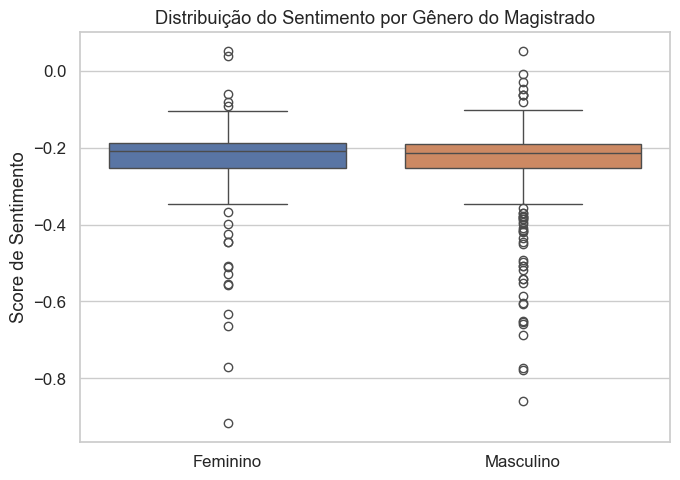

C:\Users\rafae\AppData\Local\Temp\ipykernel_7344\3897951301.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


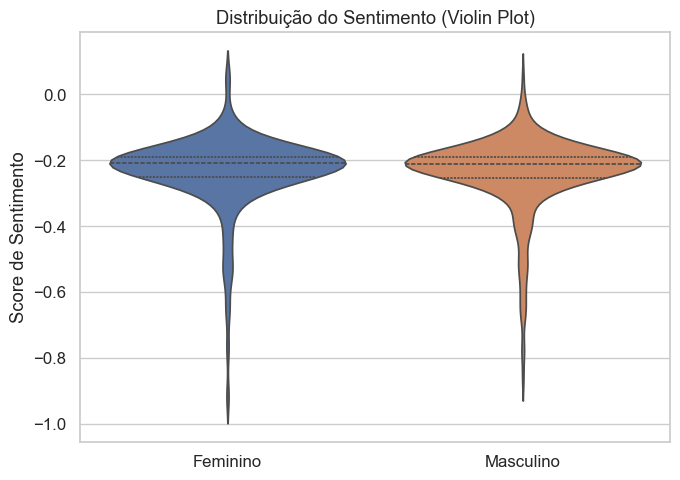

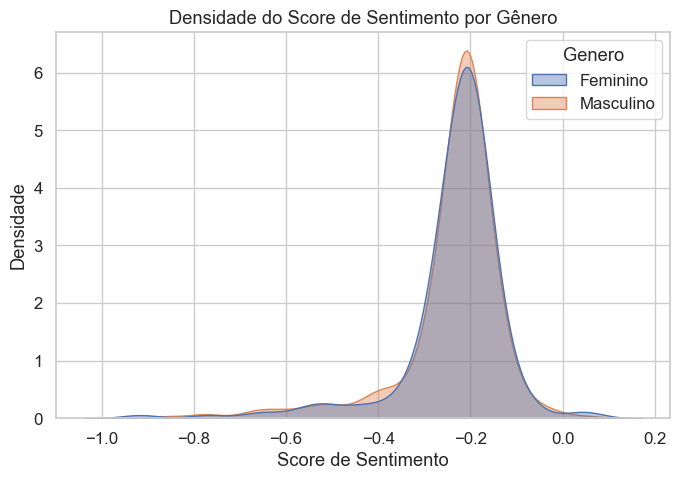

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# Carregar corpus final
# =========================
CAMINHO = r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\corpus_sentimento_tjce_516_com_sentimento.csv"

df = pd.read_csv(CAMINHO, sep=";", encoding="utf-8-sig")
df = df[df["Genero"].isin(["Masculino", "Feminino"])]

sns.set(style="whitegrid", font_scale=1.1)

# =========================
# 1. Boxplot
# =========================
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x="Genero",
    y="Sent_Score",
    palette=["#4C72B0", "#DD8452"]
)
plt.title("Distribuição do Sentimento por Gênero do Magistrado")
plt.ylabel("Score de Sentimento")
plt.xlabel("")
plt.tight_layout()
plt.show()

# =========================
# 2. Violin plot
# =========================
plt.figure(figsize=(7,5))
sns.violinplot(
    data=df,
    x="Genero",
    y="Sent_Score",
    inner="quartile",
    palette=["#4C72B0", "#DD8452"]
)
plt.title("Distribuição do Sentimento (Violin Plot)")
plt.ylabel("Score de Sentimento")
plt.xlabel("")
plt.tight_layout()
plt.show()

# =========================
# 3. Densidade (KDE)
# =========================
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="Sent_Score",
    hue="Genero",
    fill=True,
    common_norm=False,
    alpha=0.4,
    palette=["#4C72B0", "#DD8452"]
)
plt.title("Densidade do Score de Sentimento por Gênero")
plt.xlabel("Score de Sentimento")
plt.ylabel("Densidade")
plt.tight_layout()
plt.show()


In [44]:
import pandas as pd
import numpy as np
from scipy import stats

# =========================
# Preparar dados
# =========================
CAMINHO = r"C:\Users\rafae\OneDrive\Documentos\Mestrado IDP\Matérias\Deep Learning\Trabalho Final\corpus_sentimento_tjce_516_com_sentimento.csv"

df = pd.read_csv(CAMINHO, sep=";", encoding="utf-8-sig")
df = df[df["Genero"].isin(["Masculino", "Feminino"])]

# Codificação binária
df["Genero_bin"] = df["Genero"].map({"Masculino": 0, "Feminino": 1})

# =========================
# Regressão (OLS manual)
# =========================
X = df["Genero_bin"].values
y = df["Sent_Score"].values

slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print("Regressão linear simples:")
print(f"Intercepto (Masculino): {intercept:.4f}")
print(f"Coeficiente (Feminino): {slope:.4f}")
print(f"p-valor: {p_value:.4f}")
print(f"R²: {r_value**2:.6f}")



Regressão linear simples:
Intercepto (Masculino): -0.2385
Coeficiente (Feminino): 0.0033
p-valor: 0.7516
R²: 0.000195
